# How to implement your own `sktime` estimator - basics

In [1]:
# These magic functions help with interactive development
# You won't need to restart your kernel when making changes to
# the code. But they don't work with changes to classes
%load_ext autoreload
%autoreload 2

from os import sys
sys.path.append("..")

import warnings
warnings.filterwarnings('ignore')

## Contents

We'll consider this workshop successful if by the end of it you can **implement your own sktime estimators** with confidence and use them in your projects!

To achieve this, in this part of the workshop we'll cover the following:
1. Basic Developer set-up with jupyter notebooks and IDEs
2. `sktime` interfaces: public user interface vs private extension interface
3. basic steps to implement `sktime` estimators
    * example: simple sktime transformer
    * example: simple sktime forecaster
    * testing, debugging

---
## Developer Setup

In the sktime docs you can find our [developer guide](https://www.sktime.org/en/latest/developer_guide.html#developer-guide) that includes useful information like:
* **Installation**
* Git and GitHub workflow
* Continuous integration
* Coding standards
* **Implementing Estimators**
* Adding a New Dataset
* Deprecation
* **Dependencies**
* Developing Documentation
* **Sktime testing framework overview**
* Releases

This is also very useful if you want to start contributing to the project!

During this workshop we will use jupyter notebooks to demonstrate outputs etc. and an IDE to code our own estimators. For the demo we will use VS code because that's what we're used to, we suggest you do the same! i.e. use the IDE you like. 

<img src="img/nb-ide.png" width=400/>

### Workshop installation guide

First clone the repo in your laptop using the command:  
`git clone <repo-url>`  
  
Navigate to the repo clone and follow the instructions below to get your environment for the workshop up and running.  

**Simple installation:**  
Just install the dependencies (latest version of sktime, seaborne, pytest and jupyter)!  
1. `pip install -r requirements.txt`

**Using python venv:**

1. Create a python virtual environment:  
`python -m venv .venv`
2. Activate your environment:  
`source .venv/bin/activate`
3. Install the package in development mode:  
`pip install -r requirements.txt`
4. Make the environment available in jupyter:  
`python -m ipykernel install --user --name=pydata_sktime`

**Using conda env:**

1. Create a python virtual environment:  
`conda create -y -n pydata_sktime python=3.9`
2. Make sure the environment has pip:  
`conda install -y -n pydata_sktime pip`
3. Activate your environment:  
`conda activate pydata_sktime`
4. Install the package in development mode:  
`pip install -r requirements.txt`
5. Make the environment available in jupyter:  
`python -m ipykernel install --user --name=pydata_sktime`

---
## `sktime` - public user interface, private implementer interface

`sktime` estimators have two key interfaces:

* public user interface, e.g., `fit`, `predict`
    * same for all estimators of same type, e.g., forecasters
    * contract documented in base class, e.g., `BaseForecaster`
* private implementer/extender interface, e.g., `_fit`, `_predict`
    * same for all estimators of same type
    * contract documented in extension template, e.g., `forecaster_simple.py`

Why two interfaces?

We can "hide" plumbing code between `fit` and `_fit`

e.g., `_check_stuff`, `_coerce_stuff`, `_convert_stuff`, vectorization

Extender avoids copy-pasting lots of **boilerplate** every time!

<img src="img/interfaces.jpg"/>

### the public "user" interface

if this is not your first time series rodeo, you will have seen this:

In [2]:
from matplotlib import pyplot as plt
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster

# data specification
y = load_airline()

# specifying forecasting horizon
forecaster = NaiveForecaster(strategy="last", sp=12)

# fitting and predicting
fh = list(range(1, 37))
forecaster.fit(y, fh=fh)
y_pred = forecaster.predict()

public interface contract = "last 3 lines work with all forecasters" & more

let's look at the `BaseForecaster` for an example of public interface contract  [ fill in link]

from the class docs:

```
Base class template for forecaster scitype.

    class name: BaseForecaster

Scitype defining methods:
    fitting            - fit(y, X=None, fh=None)
    forecasting        - predict(fh=None, X=None)
    updating           - update(y, X=None, update_params=True)

Convenience methods:
    fit&forecast       - fit_predict(y, X=None, fh=None)
    update&forecast    - update_predict(cv=None, X=None, update_params=True)
```
and so on

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

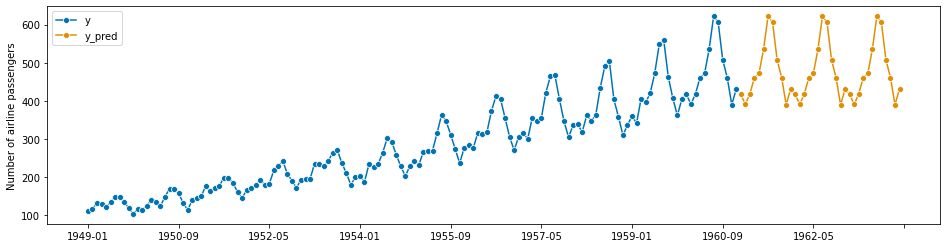

In [3]:
from sktime.utils.plotting import plot_series

plot_series(y, y_pred, labels=["y", "y_pred"])
plt.show()

### the private, "implementer/extender" interface

Private methods are for "filling in", sans boilerplate!

Largely mirror public interface, i.e., `_fit` is called in `fit`, `_predict` in `predict`

Let's have a look at the forecaster extension template! [ fill in link]

Implementers need to satisfy the "contract" in the extension template.

### the "plumbing layer"

aka killer of boilerplate

#### what happens between `fit` and `_fit`

We look into the "plumbing" layer using the excellent debugging utility [make_mock_estimator](), made by one of `sktime`'s most illustrious contributors.

`make_mock_estimator` = a testing/debugging utility that adds logging for internal method calls

In [4]:
from pprint import pprint
from sktime.utils.estimators import make_mock_estimator

forecaster_class = make_mock_estimator(NaiveForecaster)
forecaster_instance = forecaster_class()
forecaster_instance.fit(y)

fit_log = forecaster_instance.log
pprint([entry[0] for entry in fit_log])

['fit',
 'reset',
 'get_params',
 '_check_fh',
 'get_tag',
 'get_tags',
 '_check_X_y',
 'get_tag',
 'get_tags',
 'get_tag',
 'get_tags',
 'get_tag',
 'get_tags',
 'get_tag',
 'get_tags',
 '_update_y_X',
 '_set_cutoff_from_y',
 '_fit']


**What are all these methods?**
1. `fit`: Fit forecaster to `y`, optionally `X` - user sided interface.
2. `reset`: Reset the object to a clean post-init state.
3. `get_params`: Get parameters for this estimator.
4. `_check_fh`: Check forecasting horizon, coerce to `ForecastingHorizon`.
5. `get_tag`: Get tag value from estimator class and dynamic tag overrides.
6. `get_tags`: Get tags from estimator class and dynamic tag overrides.
7. `_check_X_y`: Check and coerce `X`/`y` for inner functions.
8. `_set_cutoff_from_y`: Update the `cutoff` = the "now" state of the forecaster.
9. `_fit`: Fit forecaster to `y` and `X` - "core" implementer interface.

the `get_tag` calls read tags like `y_inner_mtype`, which control the format of `y` seen in `_fit`

e.g., `pd.DataFrame`, or `np.ndarray` - **set at the preference of the implementer!**

#### what happens between `predict` and `_predict`

In [5]:
from pprint import pprint
from sktime.utils.estimators import make_mock_estimator

forecaster_class = make_mock_estimator(NaiveForecaster)
forecaster_instance = forecaster_class()
forecaster_instance.fit(y)
forecaster_instance.predict(fh=[1, 2, 3])

predict_log = forecaster_instance.log[len(fit_log):]
pprint([entry[0] for entry in predict_log])

['predict',
 'check_is_fitted',
 '_check_fh',
 'get_tag',
 'get_tags',
 '_check_X',
 '_check_X_y',
 '_predict']


**What are all these methods?**
1. `predict`: Make a forecast - user sided interface.
2. `check_is_fitted`: Check if the estimator has been fitted.
3. `_check_fh`: Check forecasting horizon, coerce to `ForecastingHorizon`.
4. `get_tag`: Get tag value from estimator class and dynamic tag overrides.
5. `get_tags`: Get tags from estimator class and dynamic tag overrides.
6. `_check_X`: Check and coerce `X`/`y` for inner functions.
7. `_check_X_y`: Check and coerce `X`/`y` for inner functions.
8. `_predict`: Make a forecast - "core" implementer interface.
9. (silent call) `convert_to`: Convert output to expected format.

### Summary:

`sktime` estimators have two key interfaces:

* public user interface, e.g., `fit`, `predict`
* a "plumbing" layer in-between, avoid boilerplate
* private user interface, e.g., `_fit`, `_predict`

Extenders need to implement content in the *private user interface*

& set tags so data, args in `_fit`, `_predict` appear in "favourite format"


---
## Implementing your own estimator

To make things easy sktime comes with it's own extension templates, you can find them here:  
https://github.com/alan-turing-institute/sktime/tree/main/extension_templates

The high-level steps to implement sktime compatible estimators are as follows:
1. identify the type of the estimator: forecaster, classifier, etc
2. copy the extension template for that kind of estimator to its intended location
3. complete the extension template
4. run the sktime test suite on the implemented estimator
5. if the test suite highlights bugs or issues, fix them and go to 4

For more information visit the [Implementing Estimators](https://www.sktime.org/en/latest/developer_guide/add_estimators.html) section in th the sktime docs

### Example 1: Implementing a min-max scaler transformer

We'll now use the transformer extension templates to implement a min-max scaler transformer.

(so step 1: it's a transformer!)

Here's what the end result will look like:

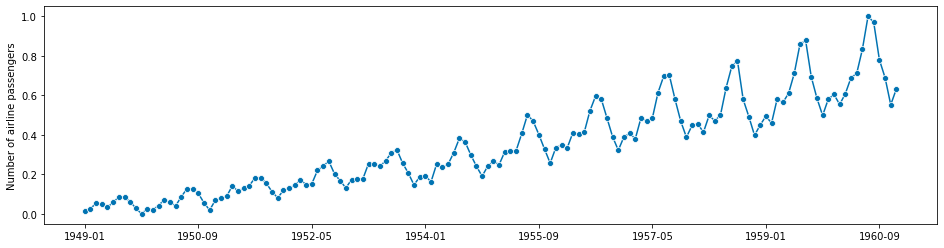

In [6]:
from pydata_sktime._2_1_2_simple_transformer_complete import MinMaxScaler

transformer = MinMaxScaler()

y_transformed = transformer.fit_transform(y)

plot_series(y_transformed)
plt.show()

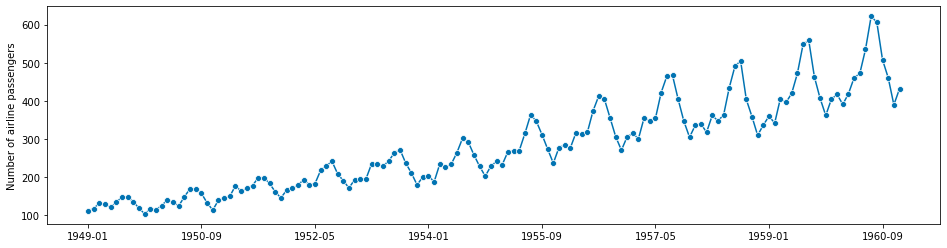

In [7]:
import numpy as np

y_inv_transformed = transformer.inverse_transform(y_transformed)

plot_series(y_inv_transformed)
plt.show()

# Check that the inverse is equal to the original
assert np.allclose(y_inv_transformed, y, atol=10**-6)

#### Steps 2 and 3: fill in the extension template 

"step 2 - copy the extension template to its desired location"

picking the simple transformer template

"step 3 - fill in the extension template"

todos indicate where work needs to be done

* docstrings! start with docstrings so know what to implement!
    * class docstring, param names
    * method docstrings
* setting tags correctly
* filling in `_fit`, `_transform`, `_inverse_transform`
* check the tags again

here's how this looks like after af first go at the todos:

*Presentation note: move to the simple transformer section pydata_sktime/\_2_1_1_simple_transformer_buggy.py*

#### Steps 4 and 5: Debugging & testing my new estimator

*How do I ensure that my new estimator is good and compatible with the sktime API?*

sktime has a [check_estimator](https://www.sktime.org/en/latest/api_reference/auto_generated/sktime.utils.estimator_checks.check_estimator.html?highlight=make_mock_estimator#sktime.utils.estimator_checks.check_estimator) utility function that runs all the automated tests based on the type and tags of the estimator. You can use this in a notebook like below or as part of your own project's unit tests.

In [8]:
from sktime.utils.estimator_checks import check_estimator

results = check_estimator(MinMaxScaler, return_exceptions=True)

FAILED: test_methods_do_not_change_state[MinMaxScaler-TransformerFitTransformSeriesUnivariate-transform]


**OH NO! A bug!** 

In [9]:
for key, val in results.items():
    if val != 'PASSED':
        print(f"Test: {key}")
        print(f"Error message: {val}")
        print("")

Test: test_methods_do_not_change_state[MinMaxScaler-TransformerFitTransformSeriesUnivariate-transform]
Error message: Estimator: MinMaxScaler changes __dict__ during transform, reason/location of discrepancy (x=after, y=before): .keys, x.keys-y.keys = {'_transformed_X_min', '_transformed_X_max'}.



*Presentation note: move to the simple transformer section pydata_sktime/pydata_sktime.\_2_1_2_simple_transformer_complete.py*

**Lets see if we fixed it**

In [10]:
from pydata_sktime._2_1_2_simple_transformer_complete import MinMaxScaler

results = check_estimator(MinMaxScaler, return_exceptions=True)

All tests PASSED!


### :-)

### Example 2: Implementing a simple moving average forecasting algorithm

We will use the extention templates to implement a simple moving average forecasting algorithm (not to be 
confused with a moving average which is not that simple).


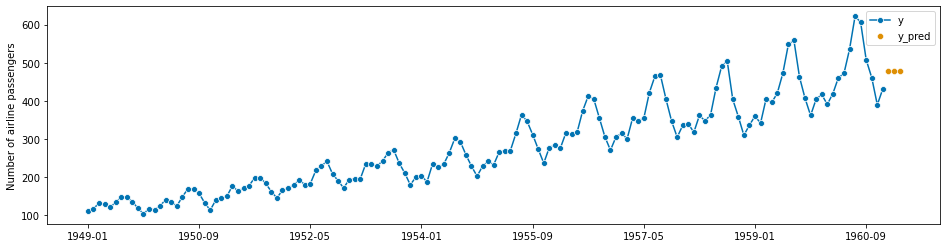

In [11]:
from pydata_sktime._2_2_1_simple_forecaster_complete import SimpleMovingAverage

forecaster = SimpleMovingAverage(window_length=5)
forecaster.fit(y)
y_pred = forecaster.predict(fh=[1, 2, 3])
plot_series(y, y_pred, labels=["y", "y_pred"])
plt.show()

*Presentation note: move to the simple forecaster sections in the codebase pydata_sktime.\_2_2_1_simple_forecaster_complete.py*

**Testing!**

In [12]:
results = check_estimator(SimpleMovingAverage, return_exceptions=False)

All tests PASSED!


---

### Credits: notebook 2 - basic extension

notebook creation: fkiraly, ltsaprounis

extension templates: fkiraly\
extension guide (developer docs): fkiraly\
forecaster base class: mloning, big-o, fkiraly, sveameyer13, miraep8\
transformer base class: mloning, fkiraly\
testing framework: mloning, fkiraly